In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from fragmenter import chemi
from openeye import oechem, oequacpac
import oenotebook as oenb
import json
import numpy as np
import glob
import cmiles
import os
from matplotlib.backends.backend_pdf import PdfPages
#import seaborn as sbn
import pandas as pd
import matplotlib.image as mpimg
import joypy

In [2]:
optimized_files = [x[0] for x in os.walk('../conjugation/geometry_opt/')][1:]

In [3]:
unoptimized_files = [x[0] for x in os.walk('../conjugation/bond_order_without_geomopt/')][1:]

In [4]:
optimized_output = {}
for kinase_inhibitor in optimized_files:
    ki_key = kinase_inhibitor.split('/')[-1]
    optimized_output[ki_key] = []
    output_files = glob.glob('../conjugation/geometry_opt/{}/*.bo.json'.format(ki_key))
    for file in output_files:
        with open(file, 'r') as f:
            data = json.load(f)
        error = data['error']
        if error:
            print(error)
            continue
        data['bond_orders'] = chemi.bond_order_from_psi4_raw_output(data['raw_output'])
        data.pop('raw_output')
        optimized_output[ki_key].append(data)

RuntimeError('\nFatal Error: Iterations did not converge.\nError occurred in file: /scratch/psilocaluser/conda-builds/psi4_1514132855674/work/psi4/src/psi4/libpsi4util/process.cc on line: 112\nThe most recent 5 function calls were:\n\npsi::die_if_not_converged()\npsi::scf::HF::finalize_E()\npsi::scf::HF::compute_energy()\n',)


In [5]:
unoptimized_output = {}
for kinase_inhibitor in unoptimized_files:
    ki_key = kinase_inhibitor.split('/')[-1]
    unoptimized_output[ki_key] = []
    output_files = glob.glob('../conjugation/bond_order_without_geomopt/{}/*.output.json'.format(ki_key))
    for file in output_files:
        with open(file, 'r') as f:
            data = json.load(f)
        error = data['error']
        if error:
            print(error)
            continue
        data['bond_orders'] = chemi.bond_order_from_psi4_raw_output(data['raw_output'])
        data.pop('raw_output')
        unoptimized_output[ki_key].append(data)

RuntimeError('\nFatal Error: Iterations did not converge.\nError occurred in file: /scratch/psilocaluser/conda-builds/psi4_1514132855674/work/psi4/src/psi4/libpsi4util/process.cc on line: 112\nThe most recent 5 function calls were:\n\npsi::die_if_not_converged()\npsi::scf::HF::finalize_E()\npsi::scf::HF::compute_energy()\n',)


In [6]:
def collect_all_std(data, hydrogen=False, rings=False, only_rings=False, aromatic=False, halogens=False, carbonyls=False, nitriles=False):

    bond_order_std = {}
    for ki in data: 
        if len(data[ki]) == 0:
            continue
        bond_order_std[ki] = {}
        conformations = len(data[ki])
        mol = cmiles.utils.load_molecule(data[ki][0]['tagged_smiles'])
        n_atoms = mol.NumAtoms()
        bond_order_wiberg = {}
        bond_order_mayer = {}
        for bond in mol.GetBonds():
            atom_1 = bond.GetBgn()
            atom_2 = bond.GetEnd()
            if not hydrogen:
                if atom_1.IsHydrogen() or atom_2.IsHydrogen():
                    continue
            if aromatic:
                if not bond.IsAromatic():
                    continue
            if only_rings and not rings:
                raise RuntimeError("If only rings is True, rings must be true")
            if only_rings:
                if not bond.IsInRing():
                    continue
            if not rings:
                if bond.IsInRing():
                    continue
            
            if not halogens:
                if atom_1.IsHalogen() or atom_2.IsHalogen():
                    continue
            if not nitriles:
                if bond.GetOrder() == 3:
                    continue
            if not carbonyls:
                if bond.GetOrder() == 2 and (atom_1.IsOxygen() or atom_2.IsOxygen()):
                    continue
            map_1 = atom_1.GetMapIdx()
            map_2 = atom_2.GetMapIdx()
            bond_order_wiberg[(map_1, map_2)] = np.zeros(conformations)
            bond_order_mayer[(map_1, map_2)] = np.zeros(conformations)

        # Populate array
        for k, d in enumerate(data[ki]):
            wiberg = d['bond_orders']['Wiberg_psi4']
            mayer = d['bond_orders']['Mayer_psi4']
            for i, j in bond_order_wiberg:
                bond_order_wiberg[(i, j)][k] = wiberg[i-1][j-1]
                bond_order_mayer[(i, j)][k] = mayer[i-1][j-1]
        bond_order_std[ki]['wiberg_bo'] = bond_order_wiberg
        bond_order_std[ki]['mayer_bo'] = bond_order_mayer
        # calculate variance
        bonds = []
        mayer_std = []
        wiberg_std = []
        for bond in bond_order_mayer:
            bonds.append(bond)
            mayer_std.append(np.std(bond_order_mayer[bond]))
            wiberg_std.append(np.std(bond_order_wiberg[bond]))  
        bond_order_std[ki]['wiberg_std'] = wiberg_std
        bond_order_std[ki]['mayer_std'] = mayer_std
        bond_order_std[ki]['bonds'] = bonds
    return bond_order_std



In [12]:
bond_order_std_rot_bonds_opt = collect_all_std(optimized_output)
bond_order_std_rot_bonds_unopt = collect_all_std(unoptimized_output)

#bond_order_std_rings_opt = collect_all_std(optimized_output, only_rings=True, rings=True)
#bond_order_std_rings_unopt = collect_all_std(unoptimized_output, only_rings=True, rings=True)

bond_order_std_aromatic_opt = collect_all_std(optimized_output, aromatic=True, rings=True)
bond_order_std_aromatic_unopt = collect_all_std(unoptimized_output, aromatic=True, rings=True)



In [8]:
import fragmenter
with open('imatinib_oe_wbo.json' ,'r') as f:
    oe_wb = json.load(f)
#deserialize keys
oe_wbo = {}
for b in oe_wb:
    b_1 = b.split('[')[-1].split(']')[0].split(',')
    b_2 = (int(b_1[0]), int(b_1[1]))
    #key = fragmenter.workflow_api.grid_id_from_str(b)
    oe_wbo[b_2] = oe_wb[b]

In [9]:
# Do an AM1BCC and ELF WBO calculation and compare
tagged_smiles = '[H:41][c:7]1[c:8]([c:3]([c:4]([n:5][c:6]1[H:40])[H:39])[c:2]2[c:1]([c:37]([n:36][c:10]([n:9]2)[N:11]([H:43])[c:12]3[c:17]([c:16]([c:15]([c:14]([c:13]3[C:35]([H:65])([H:66])[H:67])[H:44])[H:45])[N:18]([H:47])[C:19](=[O:34])[c:20]4[c:25]([c:24]([c:23]([c:22]([c:21]4[H:48])[H:49])[C:26]([H:52])([H:53])[N:27]5[C:32]([C:31]([N:30]([C:29]([C:28]5([H:54])[H:55])([H:56])[H:57])[C:33]([H:62])([H:63])[H:64])([H:58])[H:59])([H:60])[H:61])[H:50])[H:51])[H:46])[H:68])[H:38])[H:42]'
oemol = cmiles.utils.load_molecule(tagged_smiles)

# AM1BCC
charged_mol = fragmenter.chemi.get_charges(oemol)

In [10]:
copy_oemol = oechem.OEMol(oemol)
confs = chemi.generate_conformers(copy_oemol)
oequacpac.OEAssignCharges(confs, oequacpac.OEAM1BCCELF10Charges())

True

In [13]:
rot_bonds_oe = {}
for bond in bond_order_std_rot_bonds_opt['Imatinib']['wiberg_bo']:
    m1 = bond[0]
    m2 = bond[1]
    a1 = charged_mol.GetAtom(oechem.OEHasMapIdx(m1))
    a2 = charged_mol.GetAtom(oechem.OEHasMapIdx(m2))
    b = charged_mol.GetBond(a1, a2)
    rot_bonds_oe[bond] = b.GetData('WibergBondOrder')


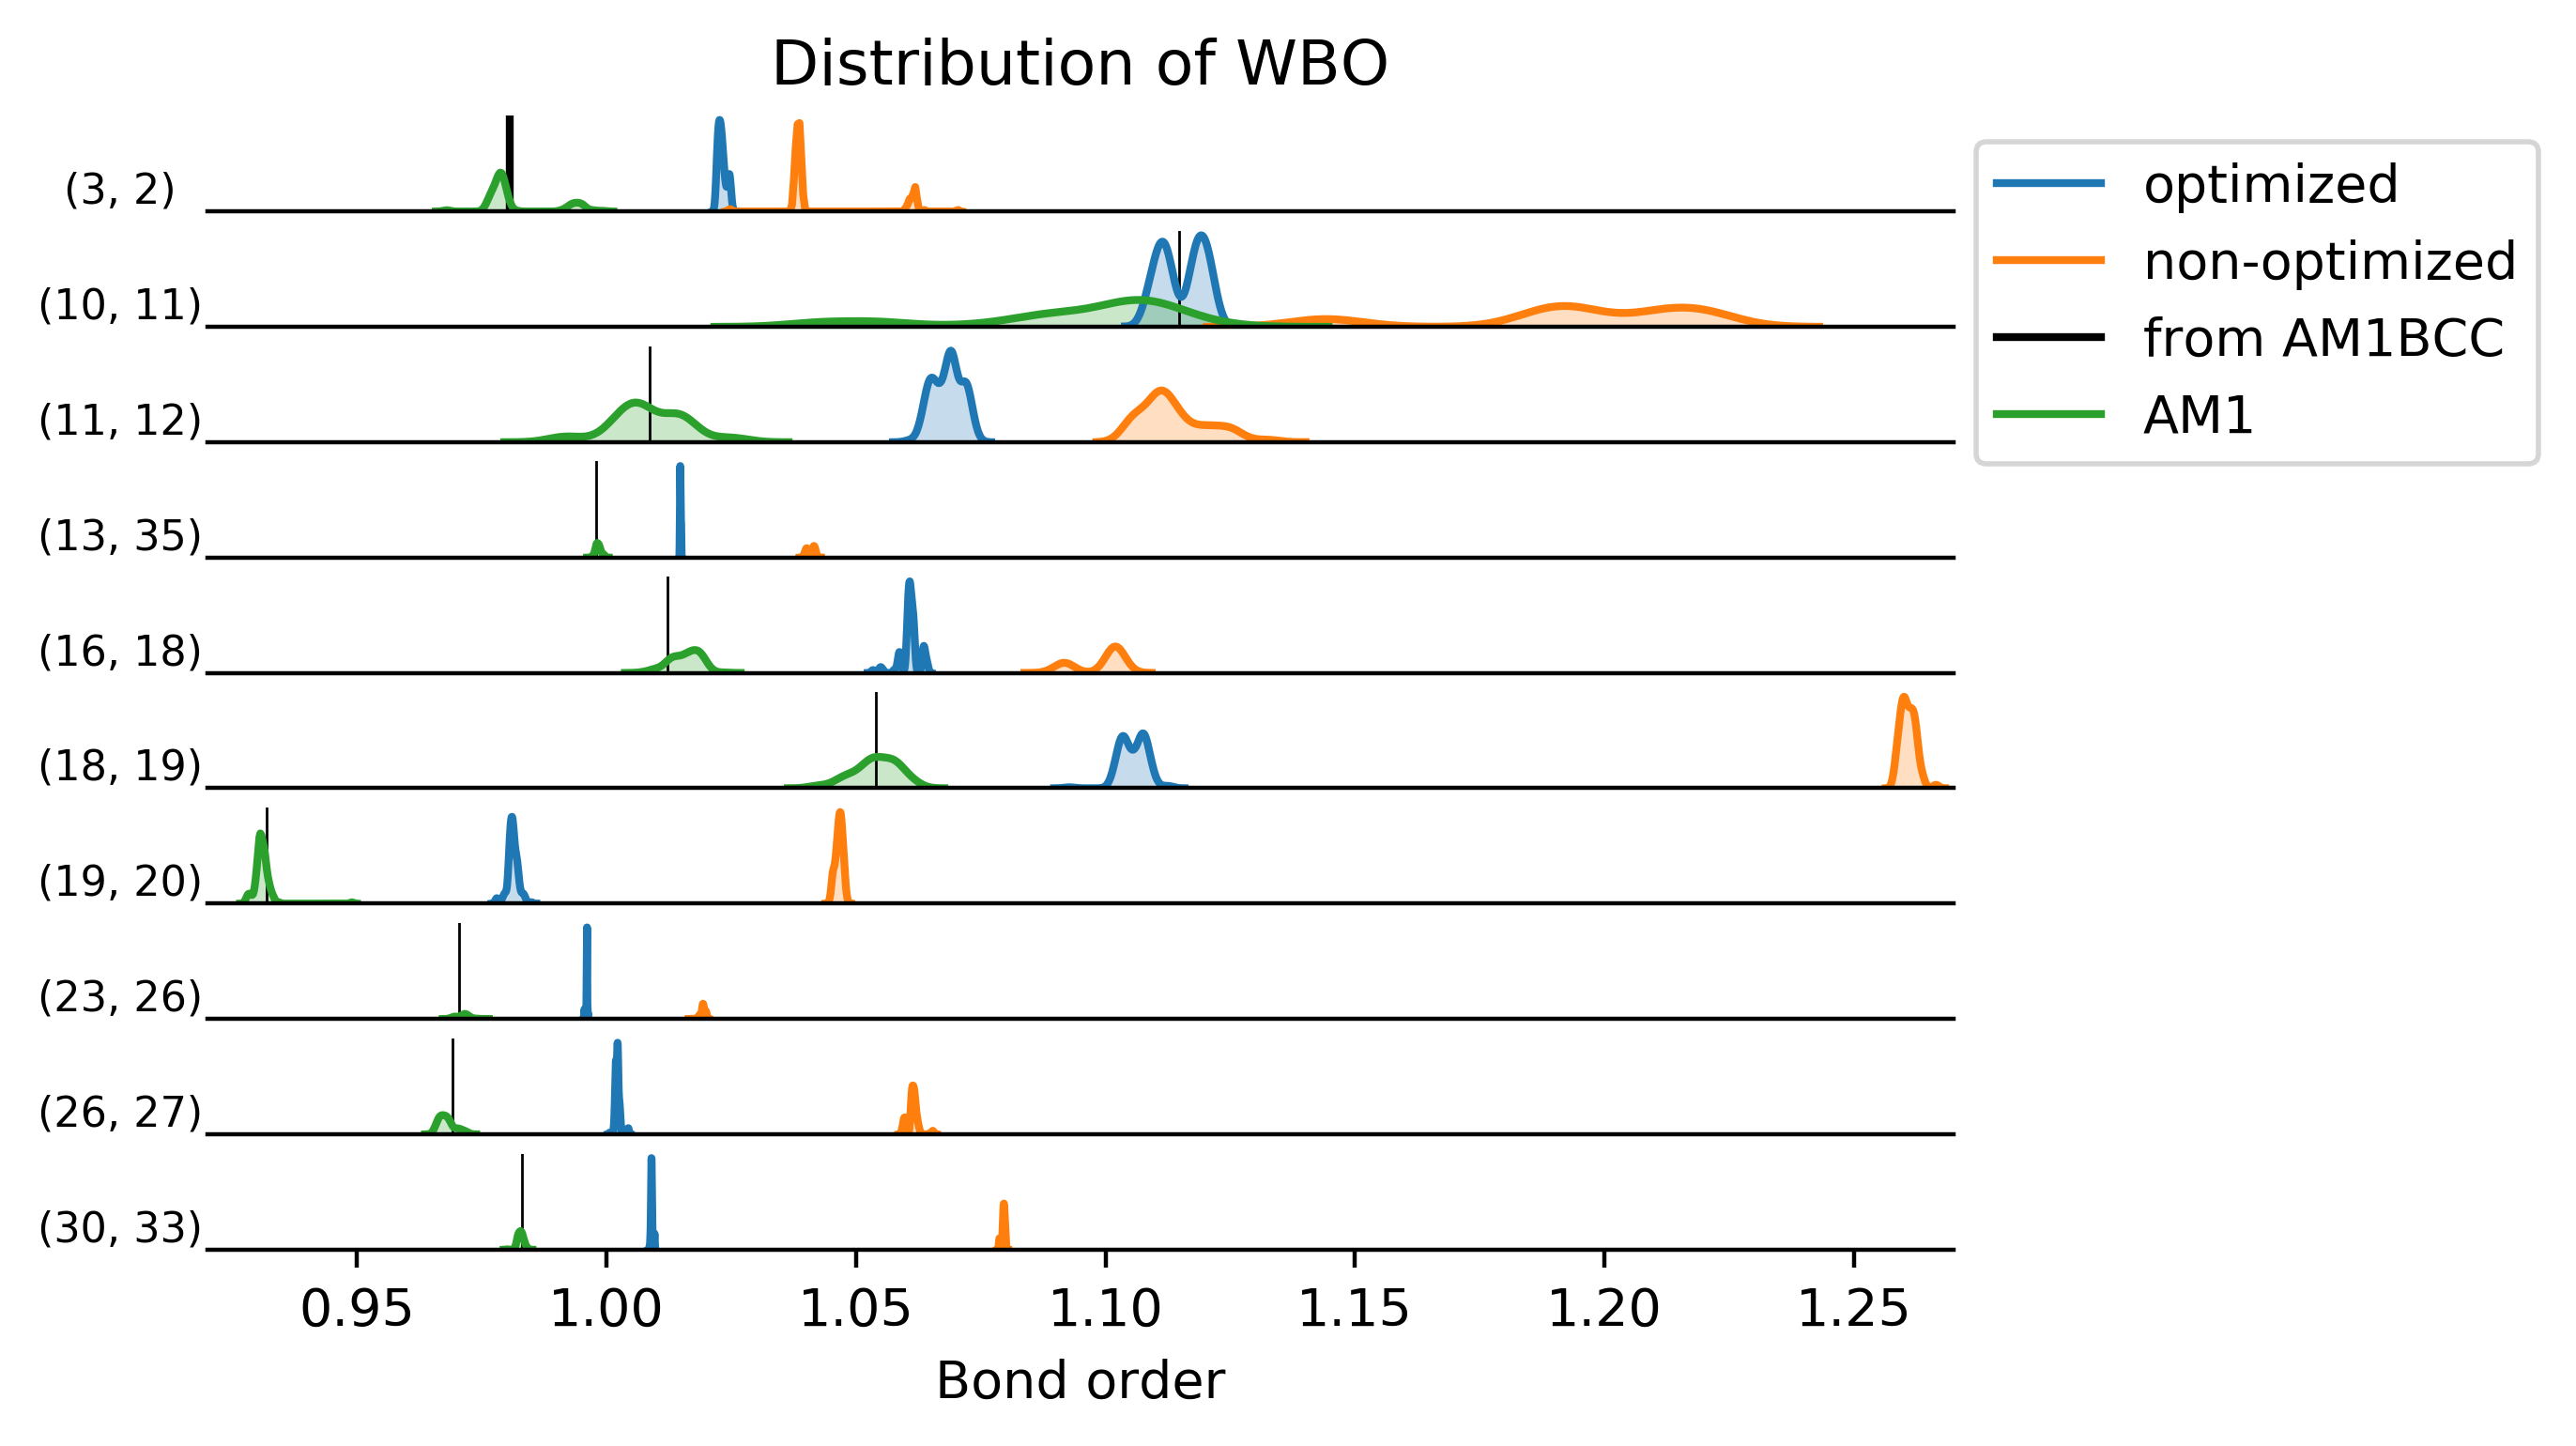

In [14]:
import seaborn as sbn

fig, axes = plt.subplots(10, 1)
fig.dpi = 400
#plt.box(False)
for i, bond in enumerate(bond_order_std_rot_bonds_opt['Imatinib']['wiberg_bo']):
    ax = plt.subplot(10, 1, i+1)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    if i == 0:
        sbn.kdeplot(bond_order_std_rot_bonds_opt['Imatinib']['wiberg_bo'][bond], shade=True, label='optimized')
        sbn.kdeplot(bond_order_std_rot_bonds_unopt['Imatinib']['wiberg_bo'][bond], shade=True, label='non-optimized')
        plt.axvline(x=rot_bonds_oe[bond], ymin=0, ymax=1, color='black', label='from AM1BCC')
        try:
            key = (bond[0]-1, bond[1]-1)
            sbn.kdeplot(oe_wbo[key], shade=True, label='AM1')
        except KeyError:
            key = (bond[-1]-1, bond[0]-1)
            sbn.kdeplot(oe_wbo[key], shade=True, label='AM1')
    else:
        plt.axvline(x=rot_bonds_oe[bond], ymin=0, ymax=1, color='black', linewidth=0.5)
        sbn.kdeplot(bond_order_std_rot_bonds_opt['Imatinib']['wiberg_bo'][bond], shade=True)
        sbn.kdeplot(bond_order_std_rot_bonds_unopt['Imatinib']['wiberg_bo'][bond], shade=True)
        try:
            key = (bond[0]-1, bond[1]-1)
            sbn.kdeplot(oe_wbo[key], shade=True)
        except KeyError:
            key = (bond[-1]-1, bond[0]-1)
            sbn.kdeplot(oe_wbo[key], shade=True)
    plt.xlim(0.92, 1.27)
    plt.yticks([])
    #ax.set_yticklabels(bond_order_std_rot_bonds_opt['Imatinib']['bonds'], fontsize=6, rotation=0)
    #ax.yaxis.grid(False)
    ax.yaxis.set_label_coords(-0.05, 0)
    plt.ylabel(bond, rotation=0, size=8)
    if i != 9:
        plt.xticks([])
    else:
        plt.xlabel('Bond order')
    if i == 0:
        plt.legend(prop={'size': 10}, bbox_to_anchor=(1.35, 1))
        plt.title('Distribution of WBO')
#overlap=0.01
#h_pad = 5 + (- 5*(1 + overlap))
#fig.tight_layout(h_pad=h_pad)
plt.savefig('imatinib_wbo_dist_oe.pdf', bbox_inches='tight')

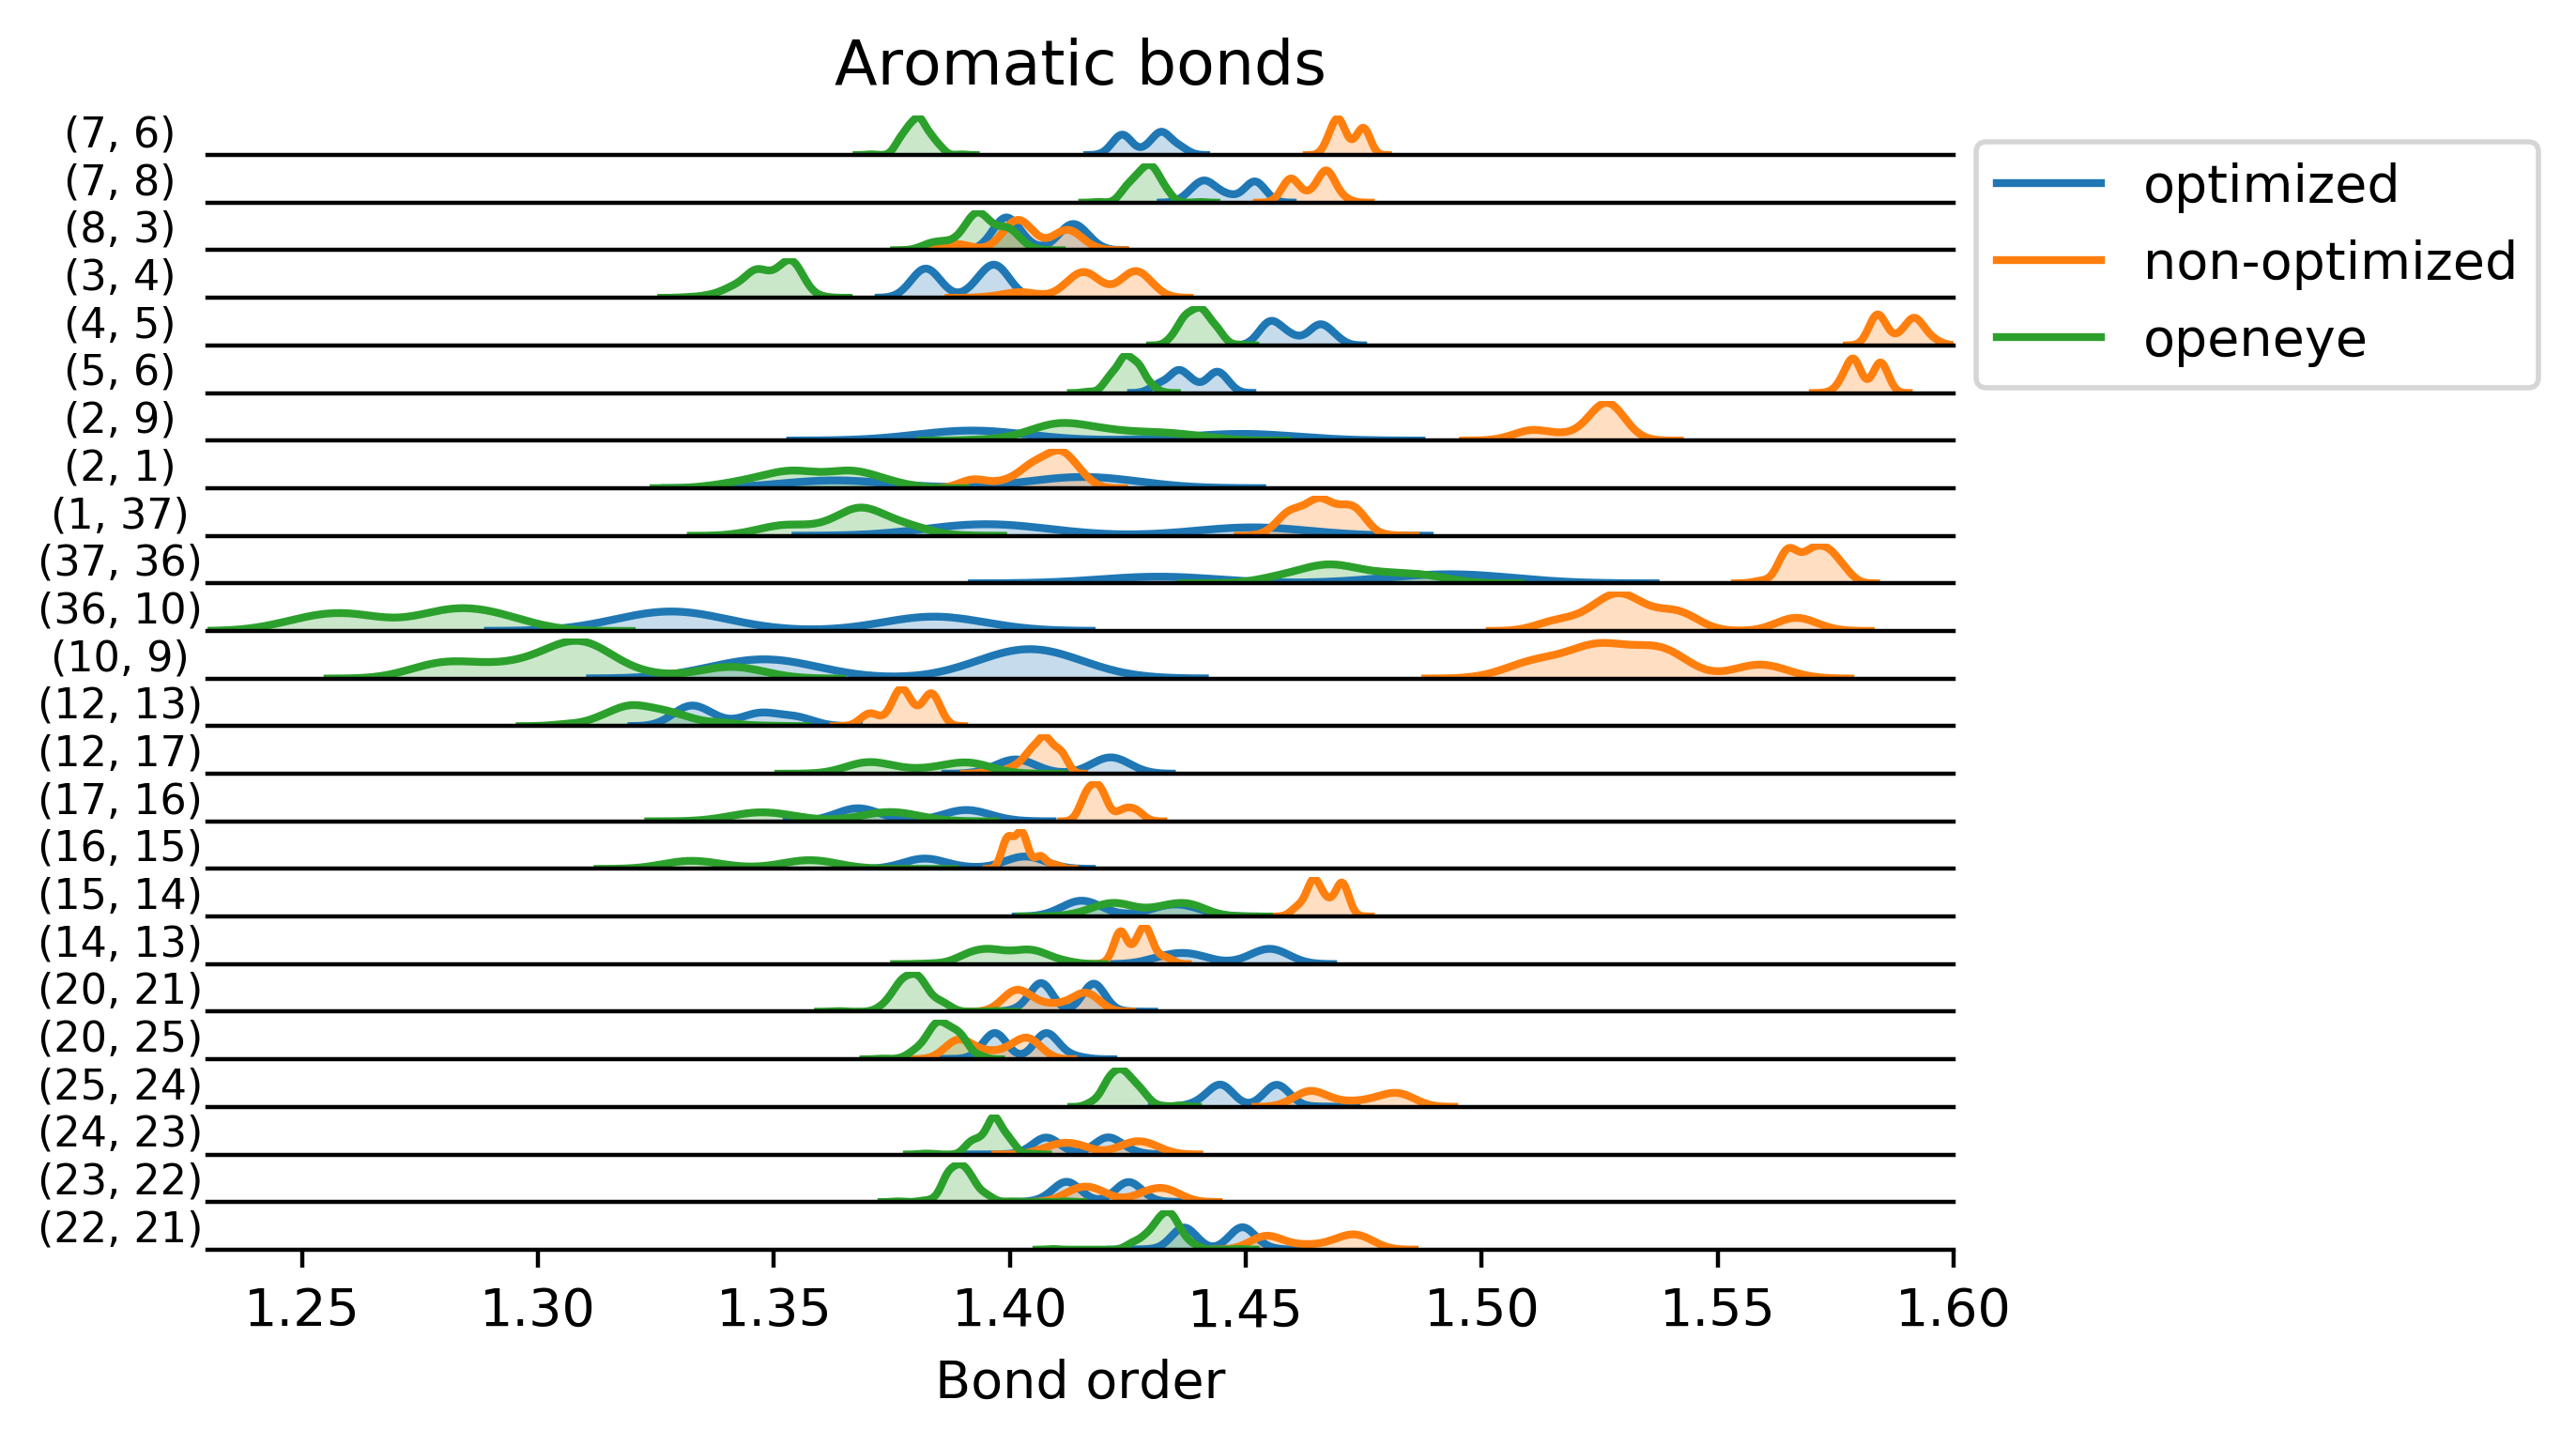

In [16]:
fig, axes = plt.subplots(24, 1)
fig.dpi = 400
#plt.box(False)
for i, bond in enumerate(bond_order_std_aromatic_opt['Imatinib']['wiberg_bo']):
    ax = plt.subplot(24, 1, i+1)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    if i == 0:
        sbn.kdeplot(bond_order_std_aromatic_opt['Imatinib']['wiberg_bo'][bond], shade=True, label='optimized')
        sbn.kdeplot(bond_order_std_aromatic_unopt['Imatinib']['wiberg_bo'][bond], shade=True, label='non-optimized')
        try:
            key = (bond[0]-1, bond[1]-1)
            sbn.kdeplot(oe_wbo[key], shade=True, label='openeye')
        except KeyError:
            key = (bond[-1]-1, bond[0]-1)
            sbn.kdeplot(oe_wbo[key], shade=True, label='openeye')
    else:
        sbn.kdeplot(bond_order_std_aromatic_opt['Imatinib']['wiberg_bo'][bond], shade=True)
        sbn.kdeplot(bond_order_std_aromatic_unopt['Imatinib']['wiberg_bo'][bond], shade=True)
        try:
            key = (bond[0]-1, bond[1]-1)
            sbn.kdeplot(oe_wbo[key], shade=True)
        except KeyError:
            key = (bond[-1]-1, bond[0]-1)
            sbn.kdeplot(oe_wbo[key], shade=True)
    plt.xlim(1.23, 1.6)
    plt.yticks([])
    #ax.set_yticklabels(bond_order_std_rot_bonds_opt['Imatinib']['bonds'], fontsize=6, rotation=0)
    #ax.yaxis.grid(False)
    ax.yaxis.set_label_coords(-0.05, 0)
    plt.ylabel(bond, rotation=0, size=8)
    if i != 23:
        plt.xticks([])
    else:
        plt.xlabel('Bond order')
    if i == 0:
        plt.legend(prop={'size': 10}, bbox_to_anchor=(1.35, 1))
        plt.title('Aromatic bonds')
#overlap=0.01
#h_pad = 5 + (- 5*(1 + overlap))
#fig.tight_layout(h_pad=h_pad)
plt.savefig('imatinib_wbo_dist_oe_rings.pdf', bbox_inches='tight')